<a href="https://colab.research.google.com/github/erikrowens/Portfolio/blob/main/ABC/ABC_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABC Classification
ABC classification is largely based on the 80/20 or Pareto rule, a metric that proposes 80% of the outcomes are determined by 20% of the inputs.

*Credit*: https://searcherp.techtarget.com/definition/ABC-classification#:~:text=ABC%20classification%20is%20a%20ranking,C%20%2D%20relatively%20unimportant

## Purpose
Provide ABC classication of sales data for a given period. The script will read in sales data for multiple stores and provide an ABC classification code for two variable at each product at each store (and then the cummulative for all stores.)

## Assumptions
1.   Source data, CSV file (rawData.csv) and parameters, YAML file (params.yaml) are both stored in the same directory on Google Drive as this notebook.
2.   Sourcing of data is clean and therefore preprocessing is not performed.
3.   Four columns of data separated by ";" (without quotes) are provided in the CSV file. The four columns are as follows: DEPOT (store code), REFERENCE (product code), VELOCITY (number of times a product was sold during the period), VOLUME (quantity of the product sold during the period.)
4.   The notebook has access to a MySQL database stored on an Amazon EC2 instanct and it will be able to create a table.





In [11]:
#@title Import Libraries
#Import 'standard' libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#To connect to Google Drive - if not permanently mounted via notebook
#from google.colab import drive
#Required to update the path statement to import a PY file from project folder
import sys
#Requirements to connect to MySQL with MySQL libraries
!pip install mysql.connector
import mysql.connector
from mysql.connector import (connection)

#Need YAML for our params file (otherwise bugs on loader=FullLoad)
!pip install -U PyYAML
import yaml

#Using PyMySQL and SQLAlchemy for inserting dataframe to MySQL
#https://www.opentechguides.com/how-to/article/pandas/195/pandas-to-mysql.html
from sqlalchemy import create_engine
!pip install -U pymysql
import pymysql

#Set the path to the current project folder
#Need to change this later so that it is not hardcoded (client independent)
#If monting in code each time
#projectFolder = '/gdrive/My Drive/Colab Notebooks/ABC Classification/'
#If permanently mounting via the notebook
projectFolder = './drive/My Drive/Colab Notebooks/ABC Classification/'

Processing /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175/mysql_connector-2.2.9-cp36-cp36m-linux_x86_64.whl
Requirement already up-to-date: PyYAML in /usr/local/lib/python3.6/dist-packages (5.3.1)
Requirement already up-to-date: pymysql in /usr/local/lib/python3.6/dist-packages (1.0.0)


In [12]:
#@title Custom class and method definitions
#Credit: https://stackoverflow.com/questions/1305532/convert-nested-python-dict-to-object
class DictToObject:
    def __init__(self, **entries):
        self.__dict__.update(entries)

def mySQLSimpleSelect(sqlString):
  cnx = connection.MySQLConnection(user=dbParams.dbUser, password=dbParams.dbPassword,host=dbParams.dbHost,database=dbParams.database)
  mycursor = cnx.cursor()
  mycursor.execute(sqlString)
  myresult = mycursor.fetchall()
  cnx.close()
  return myresult


def mergeDFOnKey(df1, df2, *colsToAdd):
  return pd.merge(left=df1, right=df2[[*colsToAdd, 'REFERENCE']], left_on='REFERENCE', right_on='REFERENCE', how='left')

def getClass(percent):
  if(percent > 0 and percent <= 50):
    theClass = 'A'
  elif(percent > 50 and percent <= 80):
    theClass = 'B'
  else:
    theClass = 'C'
  return theClass

def baseClassifier(df, depotCode):

  columnsToClassify = ['VELOCITY', 'VOLUME']
  for col in columnsToClassify:
    cumulCol = 'cumul'+col
    percentCol = 'percent'+col
    classCol = 'class'+col
    #Has problems with sort and index and warnings, etc.
    #So crate a new, temporary, DataFame for each column that we calculate
    #We will merge the temporary DataFrame back in with DF before the return
    tempDF = df.sort_values([col], ascending=False)
    tempDF = tempDF.reset_index(drop=True)
    tempDF[cumulCol] = 0

    colTotal = tempDF[col].sum()

    for i in tempDF.index:
      if(i==0):
        val = tempDF.at[i, col]
      else:
        val = tempDF.at[i-1, cumulCol] + tempDF.at[i, col]
      tempDF.at[i, cumulCol] = val
      tempDF.at[i, percentCol] = round((val / colTotal)*100, 4)
      tempDF.at[i, classCol] = getClass(tempDF.at[i, percentCol])

    #NEED TO TEST DATA AND GET CLASSIFICATION
    df = mergeDFOnKey(df, tempDF, cumulCol, percentCol, classCol)

  return df

In [13]:
#@title Mount Google Drive and/or update path
#Mount GDrive - not required if permanently mounted via notebook
#Credit: https://stackoverflow.com/questions/52808143/colab-automatic-authentication-of-connection-to-google-drive-persistent-per-n
#drive.mount('/gdrive')

#Update the path statement so that we can import our PY files for this project
sys.path.insert(1, projectFolder)

In [14]:
#@title Load client specific parameters
with open(projectFolder+'params.yaml') as paramsFile:    
    paramsDict = yaml.load(paramsFile, Loader=yaml.SafeLoader)
paramsFile.close()

#Convert our dict to an object with properties for convenience
params = DictToObject(**paramsDict)
dbParams = DictToObject(**params.dbParams)

# Load Data

In [15]:
#@title Read CSV into DataFrame
csvDelim =  params.csvDelim
freqVolCSV = 'rawData.csv'
#Need the engine='python' parameter to avoid an error of fallback to 'c'
#due to not support multiple separators different from \s
rawDataDF = pd.read_csv(projectFolder+freqVolCSV, sep=csvDelim, engine='python', dtype={'DEPOT': 'string'})

print(rawDataDF.head())
rawDataDF.info()

  DEPOT  REFERENCE  VELOCITY  VOLUME
0    NY       2017         1     4.0
1    NY       2063         2   100.0
2    NY       2568         1     1.0
3    NY       2922         2     4.0
4    NY       6219         1     3.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6059 entries, 0 to 6058
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DEPOT      6059 non-null   string 
 1   REFERENCE  6059 non-null   int64  
 2   VELOCITY   6059 non-null   int64  
 3   VOLUME     6059 non-null   float64
dtypes: float64(1), int64(2), string(1)
memory usage: 189.5 KB


# Calculate ABC
* For each store
* For all stores

## Comments


1.   It is assumed thet the CSV file contains 1 row per pair (DEPOT, REFERENCE)

## Generic Steps
> For the VELOCITY column and then for the VOLUME column 
1.   Filter the data by depot if a depot code was provided. Otherwise do not filter by depot if no depot code is provided
***For the column in question***
2.   Sort the values in ascending order
3.   Get the cummulative total
4.   Calculate the running total line-by-line
5.   Calculate the percentage of the running total as divided by the cummulative total*
6.   Apply a classification letter (A, B, or C) based on the percentage*

\* = *value to be stored in DB*

## Per depot
1.   Loop through a list of unique depot code
2.   Perform the "Generic Steps" for each store by passing the depot codes




In [16]:
#@title Calculate and classify
depotList = list(rawDataDF['DEPOT'].unique())
depotList.sort(reverse=False)

allDepotsDF = pd.DataFrame()

#For each of the individual depots
for depotCode in depotList:
  # Create a new DF, filtered by DEPOT
  depotDF = baseClassifier(rawDataDF[rawDataDF.DEPOT == depotCode], depotCode)
  #Append to allDepotDF before next loop interation
  allDepotsDF = allDepotsDF.append(depotDF[list(depotDF.columns)])

#Get cummulative for each reference at each depot
uniqueRefs = pd.unique(allDepotsDF['REFERENCE'].values)
allDepotCode = 'All'
totsDF = allDepotsDF.groupby(['REFERENCE'], as_index=False)[["VELOCITY", "VOLUME"]].sum()
totsDF['DEPOT'] = list((allDepotCode for i in range(len(uniqueRefs))))
#Rearrange columns for sanity
totsDF = totsDF[['DEPOT', 'REFERENCE', 'VELOCITY', 'VOLUME']]

depotDF = baseClassifier(totsDF[totsDF.DEPOT == allDepotCode], allDepotCode)
allDepotsDF = allDepotsDF.append(depotDF[list(depotDF.columns)])

print(allDepotsDF.head())
print(allDepotsDF[allDepotsDF.REFERENCE == 120])

#Drop columns that we do not need to store in db
allDepotsDF = allDepotsDF.drop(['cumulVELOCITY', 'cumulVOLUME'], axis=1)

  DEPOT  REFERENCE  VELOCITY  ...  cumulVOLUME  percentVOLUME  classVOLUME
0    MD       2922         4  ...         6564        78.4893            B
1    MD       6793         1  ...         7465        89.2631            C
2    MD       8604         1  ...         6594        78.8481            B
3    MD      10218         3  ...         3510        41.9710            A
4    MD      10264         1  ...         7966        95.2538            C

[5 rows x 10 columns]
  DEPOT  REFERENCE  VELOCITY  ...  cumulVOLUME  percentVOLUME  classVOLUME
0    PA        120         2  ...        19549        95.1018            C
0   All        120         2  ...        76195        98.0015            C

[2 rows x 10 columns]


In [17]:
#@title Insert results into DB
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbParams.dbHost, db=dbParams.database, user=dbParams.dbUser, pw=dbParams.dbPassword))
dbTable = 'abcClassifiedData'
allDepotsDF.to_sql(dbTable, engine, chunksize=1000, if_exists='replace')

In [18]:
#Check out the results of the insert
linesFromTable = mySQLSimpleSelect("SELECT * FROM "+dbTable+" limit 10")
for x in linesFromTable:
  print(x)

(0, 'MD', 2922, 4, 6.0, 46.9244, 'A', 78.4893, 'B')
(1, 'MD', 6793, 1, 2.0, 99.4286, 'C', 89.2631, 'C')
(2, 'MD', 8604, 1, 6.0, 81.479, 'C', 78.8481, 'B')
(3, 'MD', 10218, 3, 32.0, 60.9748, 'B', 41.971, 'A')
(4, 'MD', 10264, 1, 1.0, 81.0756, 'C', 95.2538, 'C')
(5, 'MD', 10747, 1, 1.0, 81.0084, 'C', 95.0505, 'C')
(6, 'MD', 11009, 1, 1.0, 80.9412, 'C', 95.1701, 'C')
(7, 'MD', 11303, 2, 3.0, 72.9076, 'B', 87.2183, 'C')
(8, 'MD', 11356, 1, 2.0, 80.8739, 'C', 92.7069, 'C')
(9, 'MD', 11479, 1, 1.0, 81.5798, 'C', 95.0625, 'C')


# Plot
We could read from the database but since the data is already in a dataframe we will reuse that instead.

<Figure size 432x288 with 0 Axes>

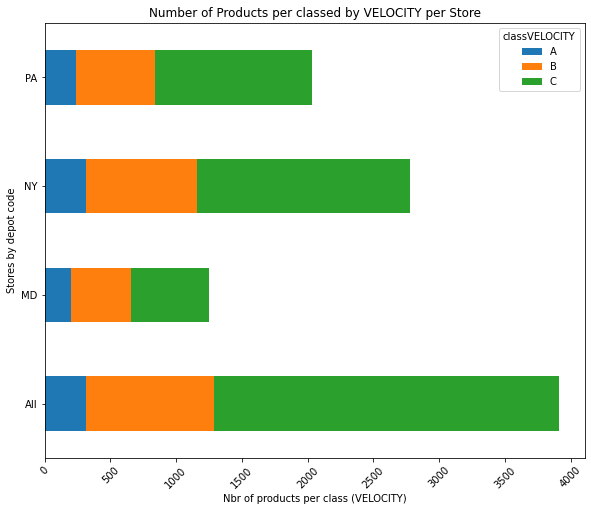

In [19]:
#@title Classed by Velocity
grouped_multiple = allDepotsDF.groupby(['DEPOT', 'classVELOCITY']).agg({'classVELOCITY': ['count']})
grouped_multiple.columns = ['nbrClassVELOCITY']
grouped_multiple = grouped_multiple.reset_index()

#Pivot our aggregated DF
gridDF = grouped_multiple.pivot(index='DEPOT',  columns='classVELOCITY', values='nbrClassVELOCITY').reset_index()

fig, ax = plt.subplots()
plt.clf()
ax = gridDF.plot(kind='barh', figsize=(10,8), stacked=True)
ax.set_yticklabels(gridDF.DEPOT)
plt.xticks(rotation=45)
plt.xlabel("Nbr of products per class (VELOCITY)")
plt.ylabel("Stores by depot code")
plt.title("Number of Products per classed by VELOCITY per Store")

plt.gcf().subplots_adjust(left=0.15)

fig = plt.gcf()
plt.draw()
plt.show()

<Figure size 432x288 with 0 Axes>

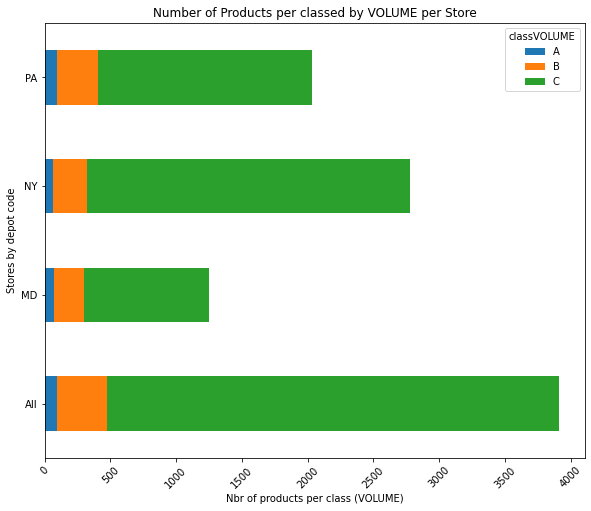

In [20]:
#@title Classed by Volume
grouped_multiple = allDepotsDF.groupby(['DEPOT', 'classVOLUME']).agg({'classVOLUME': ['count']})
grouped_multiple.columns = ['nbrClassVOLUME']
grouped_multiple = grouped_multiple.reset_index()

#Pivot our aggregated DF
gridDF = grouped_multiple.pivot(index='DEPOT',  columns='classVOLUME', values='nbrClassVOLUME').reset_index()

fig, ax = plt.subplots()
plt.clf()
ax = gridDF.plot(kind='barh', figsize=(10,8), stacked=True)
ax.set_yticklabels(gridDF.DEPOT)
plt.xticks(rotation=45)
plt.xlabel("Nbr of products per class (VOLUME)")
plt.ylabel("Stores by depot code")
plt.title("Number of Products per classed by VOLUME per Store")

plt.gcf().subplots_adjust(left=0.15)

fig = plt.gcf()
plt.draw()
plt.show()